In [1]:
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import List, Union, Callable, Tuple, Any
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Proxy income

As previously chapter, the income feature is a crucial consideration in the loan underwriting process. In this chapter, we will explore the creation of a proxy income, recognizing that it may not be entirely accurate. Despite this inherent uncertainty, it is important to find ways to manage and mitigate the risk involved. We will examine various techniques for effectively managing uncertainty in the model.

In [2]:
df = pd.read_csv("../data/00_enriched_data.csv")
df.head()
df.shape

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome,TotalIncomeBin,ApplicantIncomeBin,MonthlyPayment,TotalPay,ExpectedProfit
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,1,5849.0,"(5000, 9000]","(3500, 6000]",NaN,NaN,NaN
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0,6091.0,"(5000, 9000]","(3500, 6000]",767.424672,276272.881990,148272.881990
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1,3000.0,<= 3500,"(2500, 3500]",395.703347,142453.204776,76453.204776
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1,4941.0,"(3500, 5000]","(2500, 3500]",719.460630,259005.826866,139005.826866
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1,6000.0,"(5000, 9000]","(3500, 6000]",845.366240,304331.846568,163331.846568


(614, 19)

In [3]:
df_copy = df.dropna().copy()

## Quantile regression

Quantile regression allows us to predict the lower and upper bounds of a prediction, taking uncertainty into account. A larger gap between the bounds indicates a higher level of uncertainty and risk. By considering these factors, quantile regression can be a useful tool in managing risk when making predictions.

In [4]:
from sklearn.model_selection import train_test_split

from modeling import encode_categorical_features, encode_categorical_features_v2, encode_all, apply_encoders, rollout_result, encode_numerical_features

In [6]:
from sklearn.linear_model import QuantileRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error


common_params = dict(
    learning_rate=0.05,
    n_estimators=200,
    max_depth=5,
    min_samples_leaf=9,
    min_samples_split=9,
)


class VanillaQuantileRegression:
    def __init__(self, q: List[float] = [0.05, 0.5, 0.95], mode: int = 1):
        self.q_levels = q
        self.mode = mode
        self.models = {}
        
    def fit(self, X, y):
        for q in self.q_levels:
            if self.mode == 1:
                self.models[q] = QuantileRegressor(quantile=q)
            elif self.mode == 2:
                self.models[q] = GradientBoostingRegressor(loss="quantile", alpha=q, **common_params)
            self.models[q].fit(X, y)

    def predict(self, X, median=True) -> np.ndarray:
        preds = []
        for q in self.q_levels:
            pred = self.models[q].predict(X)
            preds.append(pred.reshape((-1, 1)))
        preds = np.concatenate(preds, axis=1)
        return preds[:, 1] if median else preds

In [7]:
train, test = train_test_split(df_copy, test_size=0.2, random_state=123)    

train_encoded, encoder = encode_all(
    df=train, 
    cat_encoder_fn=encode_categorical_features, 
    num_encoder_fn=encode_numerical_features,
    cat_features=["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area"],
    num_features=[],
    target="ApplicantIncome"
)

/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [9]:
model1 = VanillaQuantileRegression()
_ = model1.fit(
    train_encoded.drop("ApplicantIncome", axis=1), 
    train_encoded["ApplicantIncome"]
)

/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(
/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(
/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_quantile.py:295: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
Status is 4: Numerical difficulties encountered.
Result message of linprog:
The solution do

In [10]:
model2 = VanillaQuantileRegression(mode=2)
_ = model2.fit(
    train_encoded.drop("ApplicantIncome", axis=1), 
    train_encoded["ApplicantIncome"]
)

In [11]:
test_encoded = apply_encoders(
    df=test,
    encoder=encoder,
    cat_features=["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area"],
    num_features=[],
    target="ApplicantIncome"
)

In [12]:
pred1 = model1.predict(test_encoded.drop("ApplicantIncome", axis=1), False)
pred2 = model2.predict(test_encoded.drop("ApplicantIncome", axis=1), False)

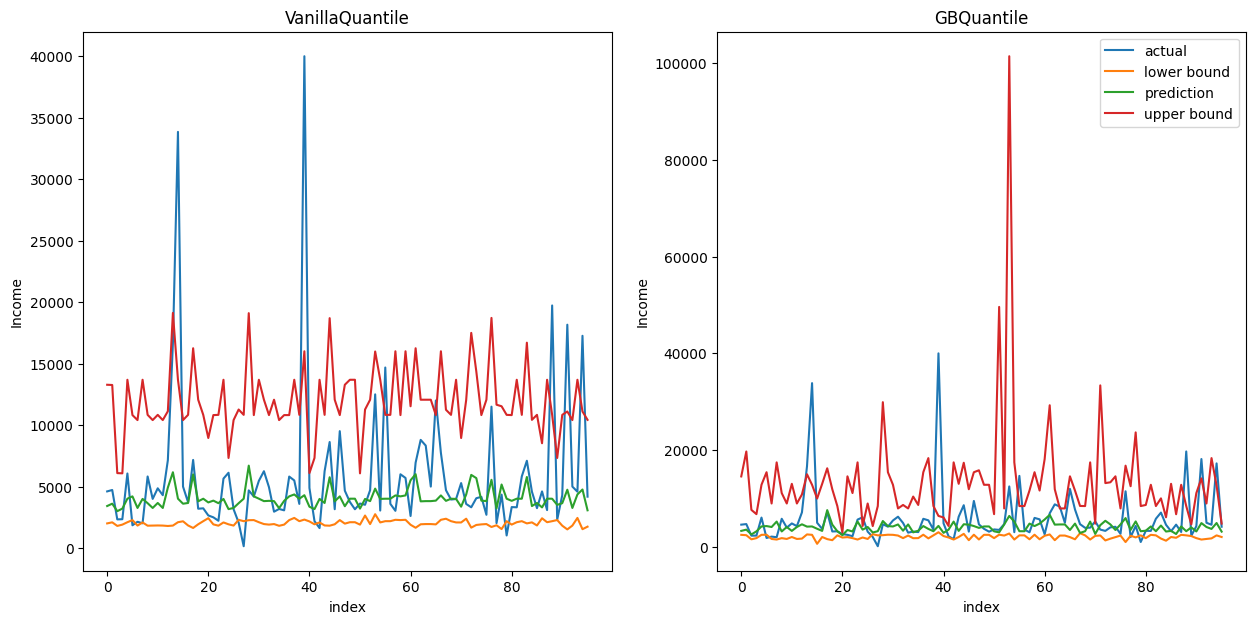

In [23]:
fig, ax = plt.subplots(figsize=(15, 7), ncols=2)

_ = ax[0].plot(test_encoded["ApplicantIncome"], label="actual")
_ = ax[0].plot(pred1[:, 0], label="lower bound")
_ = ax[0].plot(pred1[:, 1], label="prediction")
_ = ax[0].plot(pred1[:, 2], label="upper bound")
_ = ax[0].set_title("VanillaQuantile")
_ = ax[0].set_ylabel("Income")
_ = ax[0].set_xlabel("index")

_ = ax[1].plot(test_encoded["ApplicantIncome"], label="actual")
_ = ax[1].plot(pred2[:, 0], label="lower bound")
_ = ax[1].plot(pred2[:, 1], label="prediction")
_ = ax[1].plot(pred2[:, 2], label="upper bound")
_ = ax[1].set_title("GBQuantile")
_ = ax[1].set_ylabel("Income")
_ = ax[1].set_xlabel("index")
_ = plt.legend()

In [19]:
tmp1 = test_encoded[["ApplicantIncome"]].copy()
tmp1[["lower_bound", "pred", "upper_bound"]] = pred1
tmp1["range"] = tmp1["upper_bound"] - tmp1["lower_bound"]

tmp2 = test_encoded[["ApplicantIncome"]].copy()
tmp2[["lower_bound", "pred", "upper_bound"]] = pred2
tmp2["range"] = tmp2["upper_bound"] - tmp2["lower_bound"]

/var/folders/sc/ms13ry7x46nd59scs4hqmj2r0000gn/T/ipykernel_41658/3956000523.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  _ = sns.distplot(tmp1["range"], label="VanillaQuantile")
/var/folders/sc/ms13ry7x46nd59scs4hqmj2r0000gn/T/ipykernel_41658/3956000523.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  _ = sns.d

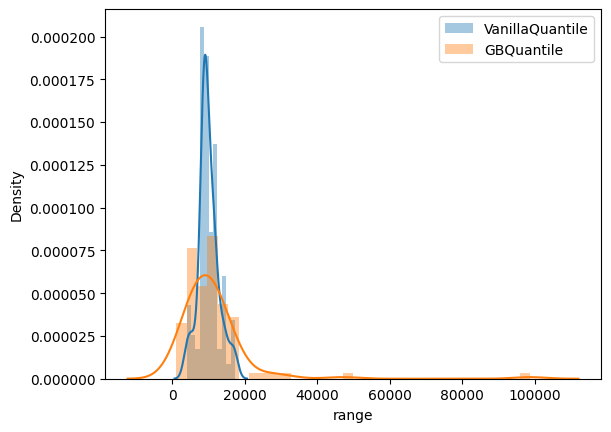

In [22]:
_ = sns.distplot(tmp1["range"], label="VanillaQuantile")
_ = sns.distplot(tmp2["range"], label="GBQuantile")
_ = plt.legend()

In [40]:
def get_exp_result(df: pd.DataFrame) -> np.ndarray:
    res = []

    for i in np.linspace(2_500, 20_000, 100):
        tt = df[
            (df["range"] <= i)
        ]
        inside_bound = tt[
            (tt["ApplicantIncome"] >= tt["lower_bound"]) & 
            (tt["ApplicantIncome"] <= tt["upper_bound"])
        ]
        res.append([i, inside_bound.shape[0] / (tt.shape[0] + 1),  tt.shape[0] / (df.shape[0] + 1)])
    res = np.array(res)
    return res


def plot_range_threshold_tradeoff(*args):
    colors = ["b", "orange", "green", "red"]
    for c, df in zip(colors, args):
        r = get_exp_result(df)
        _ = plt.plot(r[:, 0], r[:, 1], "--", c=c, label="correct rate")
        _ = plt.plot(r[:, 0], r[:, 2], c=c, label="coverage")
    
    _ = plt.xlabel("range threshold")
    _ = plt.legend()
    plt.show()

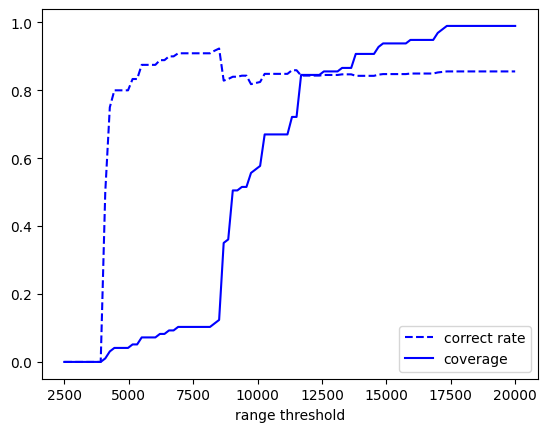

In [43]:
plot_range_threshold_tradeoff(tmp1)

**The range threshold** indicates the maximum acceptable range for selecting the predictions. For example, if the range threshold is set to 5000, this means that only predictions with a range of 5000 or less will be considered. The correct rate is then calculated based on how many examples have true income values within this bound, while the coverage reflects the number of examples with a range of 5000 or less.

As the range threshold is increased, the coverage becomes larger. However, it is important to maintain a small gap range in order to achieve both a high correct rate and a large coverage. Striking a balance between these factors is crucial in order to make accurate and reliable predictions.

At a range threshold of around 7.5K, the correct rate is the highest, but this only applies to a small percentage (around 10%) of customers. This suggests that while the prediction may be accurate for a certain range of values, it may not be generalizable to the wider population. It may be necessary to consider additional factors or to adjust the range threshold in order to improve the accuracy and applicability of the prediction.

In practice, banks generally try to avoid outright rejection of a loan application. Instead, they may look for ways to mitigate the risk associated with a particular borrower, such as by increasing the interest rate for higher-risk customers. This can be a way to balance the potential risks and profits involved in issuing a loan.

In [ ]:
# TODO: consider to use this below code in the future

# res = []
# for lower, upper in zip(np.arange(0, 20_000, 2_500), np.arange(0, 20_000, 2_500)[1:]):
#     tt = test_encoded[
#         (test_encoded["range"] <= upper) &
#         (test_encoded["range"] >= lower)
#     ]
#     inside_bound = tt[
#         (tt["ApplicantIncome"] >= tt["lower_bound"]) & 
#         (tt["ApplicantIncome"] <= tt["upper_bound"])
#     ]
#     res.append([f"[{lower}-{upper}]", inside_bound.shape[0] / (tt.shape[0] + 1),  tt.shape[0] / (test_encoded.shape[0] + 1)])
# res = pd.DataFrame(res)    

# res.columns = ["range", "correct rate", "coverage"]

# res.plot(kind="bar", x="range")
# plt.xticks(range(len(res[0])), res[0])

## Predicting bin of the income

Predicting the continuous value directly might be a bit difficult to make it accurate. In reality, treating this problem as a classification problem would be simpler to optimize and be able to get the value more quickly.

In [40]:
# mean_scores, best_model = rollout_result(
#     model_fn=lambda: CatBoostClassifier(iterations=1e3, depth=5, verbose=0),
#     df=df_copy,
#     cat_features=["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area"],
#     num_features=[],
#     target="ApplicantIncomeBin",
#     use_onehot=True
# )

In [41]:
# mean_scores

In [42]:
train, test = train_test_split(df_copy, test_size=0.2, random_state=123)

train_encoded, encoder = encode_all(
    df=train, 
    cat_encoder_fn=encode_categorical_features_v2, 
    num_encoder_fn=encode_numerical_features,
    cat_features=["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area"],
    num_features=[],
    target="ApplicantIncomeBin"
)

In [43]:
model = CatBoostClassifier(iterations=1e3, depth=5, verbose=0)
_ = model.fit(
    train_encoded.drop("ApplicantIncomeBin", axis=1), 
    train_encoded["ApplicantIncomeBin"]
)

In [44]:
test_encoded = apply_encoders(
    df=test,
    encoder=encoder,
    cat_features=["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area"],
    num_features=[],
    target="ApplicantIncomeBin"
)

In [45]:
test.reset_index(drop=True, inplace=True)

test["pred"] = model.predict(test_encoded.drop("ApplicantIncomeBin", axis=1))

In [46]:
print(
    classification_report(
        test_encoded["ApplicantIncomeBin"],
        test["pred"],
        labels=applicant_income_bin_names
    )
)

               precision    recall  f1-score   support

      <= 2500       0.14      0.07      0.10        14
 (2500, 3500]       0.16      0.28      0.20        18
 (3500, 6000]       0.37      0.37      0.37        41
(6000, 10000]       0.08      0.08      0.08        13
      > 10000       0.25      0.10      0.14        10

     accuracy                           0.24        96
    macro avg       0.20      0.18      0.18        96
 weighted avg       0.24      0.24      0.23        96



In [47]:
pd.DataFrame(
    confusion_matrix(
        test_encoded["ApplicantIncomeBin"],
        test["pred"],
        labels=applicant_income_bin_names
    ),
    index=applicant_income_bin_names,
    columns=applicant_income_bin_names
)

,<= 2500,"(2500, 3500]","(3500, 6000]","(6000, 10000]",> 10000
<= 2500,1,5,5,3,0
"(2500, 3500]",3,5,9,1,0
"(3500, 6000]",3,15,15,6,2
"(6000, 10000]",0,2,9,1,1
> 10000,0,5,3,1,1


The confusion matrix allows us to analyze the results of a prediction in terms of overprediction and underprediction. Each row represents the true label, while each column represents the predicted label. Overprediction for a given class (e.g. $i^{th}$) occurs when the predicted label (e.g. $j^{th}$) is greater than the true label. Underprediction, on the other hand, occurs when the predicted label is less than the true label.

Banks generally prefer to take a lower risk when it comes to underprediction, as it involves estimating a borrower's income as lower than it actually is. However, this also means that they may miss out on opportunities to earn higher profits.

In [48]:
n_underprediction = 3 + 3 + 15 + 0 + 2 + 9 + 0 + 5 + 3 + 1
n_overprediction = 5 + 5 + 3 + 0 + 9 + 1 + 0 + 6 + 2 + 1
n_correct = 1 + 5 + 15 + 1 + 1

test.shape[0], n_correct, n_underprediction, n_overprediction

(96, 23, 41, 32)

## Conformal prediction

Conformal prediction [[2]]() is a method for generating prediction sets for any model without the need for modification. It allows for the construction of prediction sets that meet the following criteria:

$$
1 - \alpha \le \mathbb{P}(Y_{test} \in C(X_{test})) \le 1 - \alpha + \frac{1}{n+1}
$$

where:

$\alpha$ is the error rate

$C(X_{test})$ is the prediction set

There are three steps to using this method:

* Obtain the score $s$, where higher scores indicate worse agreement between $x$ and $y$.
* Determine the quantile of the score, $\hat{q}$.
* Form the prediction set $C(X_{test}) = {y: s(X_{test}, y) \le \hat{q}}$.

**Split the data into 3 sets (train, calibrate, test)**

In [49]:
df_copy["ApplicantIncomeBin"].value_counts()

(3500, 6000]     164
(2500, 3500]     121
<= 2500           83
(6000, 10000]     71
> 10000           41
Name: ApplicantIncomeBin, dtype: int64

In [50]:
train, test = train_test_split(df_copy, test_size=0.2, random_state=123)  # 80, 20
train, calibrate = train_test_split(train, test_size=0.3, random_state=123)

In [51]:
df_copy.shape, train.shape, calibrate.shape, test.shape

((480, 19), (268, 19), (116, 19), (96, 19))

In [52]:
train_encoded, encoder = encode_all(
    df=train, 
    cat_encoder_fn=encode_categorical_features_v2, 
    num_encoder_fn=encode_numerical_features,
    cat_features=["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area"],
    num_features=[],
    target="ApplicantIncomeBin"
)

**Training the model**

In [53]:
model = CatBoostClassifier(verbose=0)

_ = model.fit(
    train_encoded.drop("ApplicantIncomeBin", axis=1), 
    train_encoded["ApplicantIncomeBin"]
)

In [54]:
calibrate_label_index = calibrate["ApplicantIncomeBin"].map(lambda x: list(model.classes_).index(x))

In [55]:
calibrate_encoded = apply_encoders(
    df=calibrate,
    encoder=encoder,
    cat_features=["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area"],
    num_features=[],
    target="ApplicantIncomeBin"
)

test_encoded = apply_encoders(
    df=test,
    encoder=encoder,
    cat_features=["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area"],
    num_features=[],
    target="ApplicantIncomeBin"
)

**Conformal prediction**

In [56]:
alpha = 0.1
n = calibrate.shape[0]

scores = 1 - model.predict_proba(calibrate_encoded.drop("ApplicantIncomeBin", axis=1))[np.arange(n), calibrate_label_index]
q_level = np.ceil((n+1) * (1-alpha)) / n
qhat = np.quantile(scores, q_level, method="higher")

In [57]:
prob_pred = model.predict_proba(test_encoded.drop("ApplicantIncomeBin", axis=1))

<AxesSubplot: ylabel='Count'>

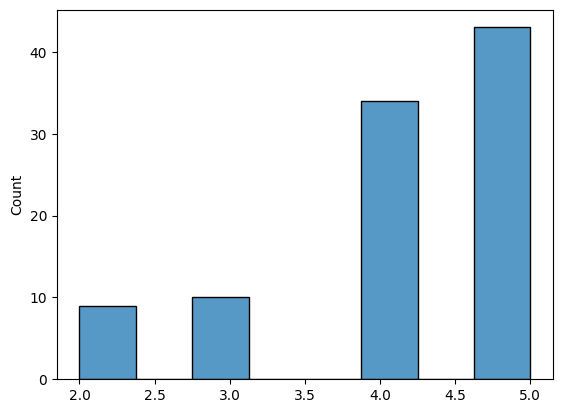

In [58]:
sns.histplot(list(map(lambda x: len(model.classes_[x]), prob_pred >= (1-qhat))))

In [59]:
from pprint import pprint

In [60]:
res = []

for i, x in enumerate(list(map(lambda x: model.classes_[x], prob_pred >= (1-qhat)))):
    print(x, test.iloc[i]["ApplicantIncomeBin"], sep="|")
    res.append(
        test.iloc[i]["ApplicantIncomeBin"] in x
    )

['(2500, 3500]' '(6000, 10000]' '<= 2500' '> 10000']|(3500, 6000]
['(2500, 3500]' '(3500, 6000]' '(6000, 10000]' '> 10000']|(3500, 6000]
['(2500, 3500]' '(3500, 6000]' '(6000, 10000]' '<= 2500']|<= 2500
['(2500, 3500]' '(3500, 6000]' '(6000, 10000]' '<= 2500']|<= 2500
['(2500, 3500]' '(3500, 6000]' '(6000, 10000]' '<= 2500' '> 10000']|(6000, 10000]
['(2500, 3500]' '(3500, 6000]' '(6000, 10000]' '> 10000']|<= 2500
['(2500, 3500]' '(3500, 6000]' '(6000, 10000]']|<= 2500
['(2500, 3500]' '(3500, 6000]' '(6000, 10000]' '<= 2500' '> 10000']|<= 2500
['(2500, 3500]' '(3500, 6000]' '(6000, 10000]' '<= 2500' '> 10000']|(3500, 6000]
['(2500, 3500]' '(3500, 6000]' '(6000, 10000]']|(3500, 6000]
['(2500, 3500]' '(3500, 6000]' '(6000, 10000]' '<= 2500' '> 10000']|(3500, 6000]
['(2500, 3500]' '(3500, 6000]' '(6000, 10000]']|(3500, 6000]
['(2500, 3500]' '(3500, 6000]' '(6000, 10000]' '<= 2500' '> 10000']|(6000, 10000]
['(2500, 3500]' '(3500, 6000]' '(6000, 10000]' '<= 2500' '> 10000']|> 10000
['(2500, 

In [61]:
np.mean(res)

0.90625

This number means 90% of the prediction set contains the true label.

# References

1. [Loan Prediction w/ Various ML Models](https://www.kaggle.com/code/caesarmario/loan-prediction-w-various-ml-models/notebook)
2. [A Gentle Introduction to Conformal Prediction and Distribution-Free Uncertainty Quantification](https://arxiv.org/abs/2107.07511)
3. [Mortgage Calculator](https://www.bankrate.com/mortgages/mortgage-calculator/)